# Setup

In [1]:
import figure_utilities
import constants
from stats_utilities import test_balance, run_event_study, run_did_in_R, run_sensitivity_analysis_in_R
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['savefig.dpi'] = 300
import os
import statsmodels.api as sm
from stats_utilities import run_event_study
from differences import ATTgt
import pandas as pd
import numpy as np
from os.path import join

In [2]:
# Store paths.
INPUT_DATA_PANEL = "../data/03_cleaned/crime_analysis_monthly.csv"
INPUT_DATA_EVICTIONS = "../data/02_intermediate/evictions.csv"
OUTPUT_TABLES = "../output/final_paper/tables"
OUTPUT_FIGURES = "../output/final_paper/figures"
OUTPUT_STATISTICS = "../output/final_paper/main_results_numbers_to_cite.tex"

## Crime Levels Around Filing Date and Latest Docket Date

In [3]:
# Get share of properties for which geocoded coordinates lie within the associated tax parcel 
df = pd.read_csv(INPUT_DATA_EVICTIONS)
share_correct_tax_parcel = df['Accuracy Type'].value_counts(normalize=True).loc['rooftop']
print(f"{share_correct_tax_parcel} is the share of properties for which the geocoded coordinates lie within the associated tax parcel")
# See https://www.geocod.io/guides/accuracy-types-scores/ for more information 

0.9344937068867446 is the share of properties for which the geocoded coordinates lie within the associated tax parcel


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/79098691.py:2: DtypeWarning: Columns (19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_EVICTIONS)


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/713859008.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/713859008.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/713859008.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


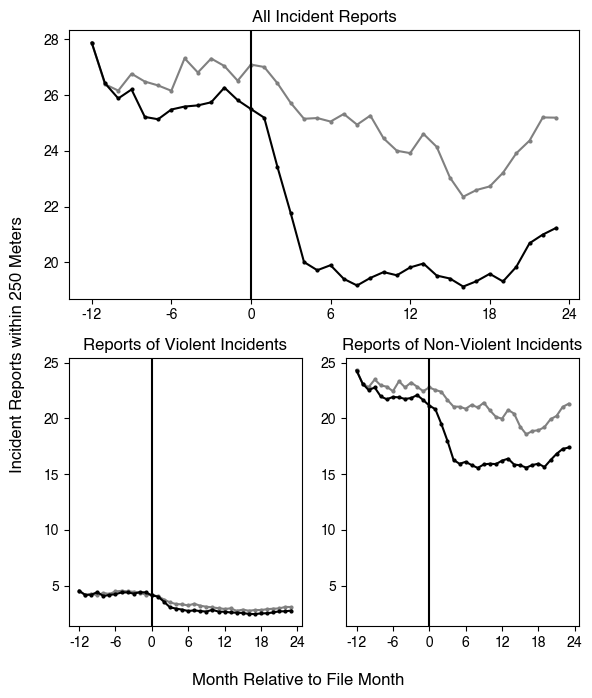

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/713859008.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/713859008.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/713859008.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


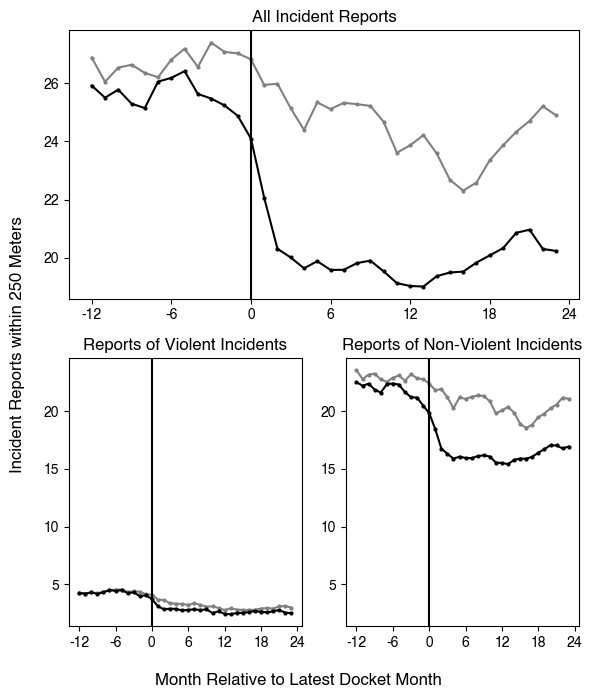

In [4]:
for treatment_date_variable in ['file_month', 'latest_docket_month']:
    
    fig = plt.figure(figsize=(6, 7))
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1], sharey=ax2)
    axes = [ax1, ax2, ax3]
    titles = ["All Incident Reports", "Reports of Violent Incidents", "Reports of Non-Violent Incidents"]
    for group, (ax, title) in enumerate(zip(axes, titles)):
        df = pd.read_csv(INPUT_DATA_PANEL)
        result = run_event_study(df,
                                    treatment_date_variable,
                                    f'group_{group}_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')
        # Normalize omitted period to zero
        omitted_period = pd.Series([0, 0], index=['month_-1', 'month_-1_X_treatment_indicator'])
        result.params = pd.concat([result.params, omitted_period], axis=0)
        month = []
        treatment = []
        control = []
        for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD):
            month.append(i)
            control.append(result.params[f'month_{i}'] + result.params['const'])
            treatment.append((result.params['judgment_for_plaintiff'] +
                               result.params[f'month_{i}_X_treatment_indicator'] +
                               result.params[f'month_{i}']  +
                              result.params['const']))
    
        l2, = ax.plot(month,
            control,
            color='grey',
            linestyle='-',
            marker='o',
            markersize=2,
            label="Properties where Tenant Won")
        l1, = ax.plot(month,
                treatment,
                color='black',
                linestyle='-',
                marker='o',
                markersize=2,
                label="Properties where Plaintiff Won")
        if title == "All Crimes":
            ax.legend(loc="lower right")
            ax.set_yticks(list(range(0, 35, 5)))

        ax.axvline(0, color='black')
        ax.set_title(title)
        ax.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD + 1, 6),
                      range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD + 1, 6))
    supxlabel = "Month Relative to File Month" if treatment_date_variable == 'file_month' else "Month Relative to Latest Docket Month"
    fig.supxlabel(supxlabel)
    fig.supylabel(f"Incident Reports within {constants.Analysis.MAIN_RESULTS_RADIUS} Meters")
    plt.tight_layout()
    plt.show()
    figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"crime_trends_around_{treatment_date_variable}_all_groups.png"))

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3638145396.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


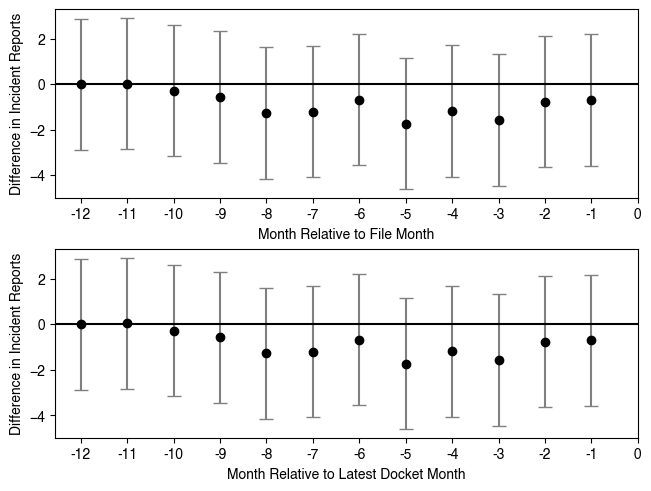

In [5]:
df = pd.read_csv(INPUT_DATA_PANEL)
result_file_month = run_event_study(df,
                                       'file_month',
                                       f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')
result_latest_docket_month = run_event_study(df,
                                       'latest_docket_month',
                                       f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')

file_month_point_estimates = []
file_month_p_values = []
latest_docket_month_point_estimates = []
latest_docket_month_p_values = []
file_month_standard_errors = []
latest_docket_month_standard_errors = []
for result, point_estimates, p_values, standard_errors in zip([result_file_month, result_latest_docket_month],
                                                              [file_month_point_estimates, latest_docket_month_point_estimates],
                                                              [file_month_p_values, latest_docket_month_p_values],
                                                              [file_month_standard_errors, latest_docket_month_standard_errors]):
    for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, -1):
        hypothesis = f"month_{i}_X_treatment_indicator + judgment_for_plaintiff = 0"
        t_test = result.t_test(hypothesis)
        point_estimates.append(result.params[f'month_{i}_X_treatment_indicator'] + result.params['judgment_for_plaintiff'])
        p_values.append(t_test.pvalue)
        standard_errors.append(t_test.sd)
    # Hypothesis test for omitted category
    hypothesis = f"judgment_for_plaintiff = 0"
    t_test = result.t_test(hypothesis)
    point_estimates.append(result.params['judgment_for_plaintiff'])
    p_values.append(t_test.pvalue)
    standard_errors.append(t_test.sd)


fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')
months = list(range(constants.Analysis.MINIMUM_PRE_PERIOD, 0))
ax1.errorbar(months, file_month_point_estimates, 1.96 * np.array(latest_docket_month_standard_errors).flatten(), ecolor='grey', color='black', marker='o', linestyle='', capsize=5)
ax1.set_xlabel("Month Relative to File Month")
ax1.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1),
               range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1))
ax1.set_ylabel("Difference in Incident Reports")


ax2.errorbar(months, file_month_point_estimates, 1.96 * np.array(file_month_standard_errors).flatten(), ecolor='grey', color='black', marker='o', linestyle='', capsize=5)
ax2.set_xlabel("Month Relative to Latest Docket Month")
ax2.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1),
               range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1))
ax2.set_ylabel("Difference in Incident Reports")

figure_utilities.plot_labeled_hline(ax1, y=0, text="", color='black', linestyle='-', zorder=6)
figure_utilities.plot_labeled_hline(ax2, y=0, text="", color='black', linestyle='-', zorder=6)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"levels_test.png"))

In [58]:
# Calculate percentage fall in all crimes in the treatment group
treatment_group_month_0_level = result_file_month.params.loc[['month_0', 'judgment_for_plaintiff', 'month_0_X_treatment_indicator', 'const']].sum()
treatment_group_month_3_level = result_file_month.params.loc[['month_3', 'judgment_for_plaintiff', 'month_3_X_treatment_indicator', 'const']].sum()
percent_fall_treatment_group = round(100 * ((treatment_group_month_0_level - treatment_group_month_3_level) / treatment_group_month_0_level), 2)
# Calculate percentage fall in all crimes in the control group
percent_fall_control_group = \
    round(100 *((result_latest_docket_month.params.loc['month_0'] - result_latest_docket_month.params.loc['month_3']) / (result_latest_docket_month.params.loc['month_0']+ result_latest_docket_month.params.loc['const'])), 2)

In [62]:
smallest_post_treatment_percent_change

12.19

In [63]:
# Calculate minimum post-treatment difference in percent terms between treatment and control group 
post_treatment_gaps_as_pct_of_control_group = []
for post_treatment_period in range(4, 22):
    post_treatment_gap = -1 *result_latest_docket_month.params.loc[['judgment_for_plaintiff', f'month_{post_treatment_period}_X_treatment_indicator']].sum()
    post_treatment_gap_as_pct_of_control_group = round((100 * (post_treatment_gap / (result_latest_docket_month.params.loc[f'month_{post_treatment_period}'] + result_latest_docket_month.params.loc['const']))), 2)
    post_treatment_gaps_as_pct_of_control_group.append(post_treatment_gap_as_pct_of_control_group)
smallest_post_treatment_percent_change = min(post_treatment_gaps_as_pct_of_control_group)

In [98]:
df = pd.read_csv(INPUT_DATA_PANEL)
treatment_date_variable = 'file_month'
analysis = f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m'
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
# Re-Balance on Controls
balance_table = test_balance(df, analysis, None)
balance_table = figure_utilities.add_column_numbers(balance_table)

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/2750253292.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


Optimization terminated successfully.
         Current function value: 0.679216
         Iterations 4


In [99]:
balance_table

\
                                        Cases Won by Defendant   
                                                           (1)   
Panel A All Police Responses, 2017                  351.770393   
        All Police Responses, Month -12              27.889728   
        All Police Responses, Month -6               26.158610   
Panel B Median household income, 2016             45239.433535   
        Poverty rate, 2010                            0.304734   
        Population density, 2010                  23875.350376   
        Share white, 2010                             0.317967   
Panel C Filing for nonpayment                         0.882175   

                                        Difference in Cases Won by Plaintiff  \
                                                                  Unweighted   
                                                                         (2)   
Panel A All Police Responses, 2017                                 -2.637661   
        All Police Responses, Month -12                            -0.005707   
        All Police Responses, Month -6                             -0.672786   
Panel B Median household income, 2016                            3601.548401   
        Poverty rate, 2010                                         -0.033414   
        Population density, 2010                                 -962.358983   
        Share white, 2010                                           0.000810   
Panel C Filing for nonpayment                                      -0.103825   

                                                                              
                                             \emph{p}     Weighted  \emph{p}  
                                                  (3)          (4)       (5)  
Panel A All Police Responses, 2017       8.510647e-01   -14.307971  0.313917  
        All Police Responses, Month -12  9.958638e-01    -1.084560  0.330101  
        All Police Responses, Month -6   5.248381e-01    -0.921351  0.380798  
Panel B Median household income, 2016    8.631704e-03 -2611.106866  0.071246  
        Poverty rate, 2010               2.371944e-05    -0.007771  0.317310  
        Population density, 2010         2.072921e-01  -921.733181  0.223314  
        Share white, 2010                9.555954e-01    -0.019251  0.194335  
Panel C Filing for nonpayment            2.015986e-07    -0.036182  0.088759

In [10]:
filename = join(OUTPUT_TABLES, "balance_table.tex")
latex = (balance_table
         .rename(index=constants.Variables.variable_display_names_dict)
         .style
         .format(thousands=",",
                 na_rep='',
                 formatter="{:,.2f}")
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llccccc",
                   hrules=True,
                   multicol_align='c',
                   clines="skip-last;data")).replace("{*}", "{3cm}")
latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{4-7}\n")
latex = "\\\\\n".join(latex)

with open(filename, 'w') as file:
    file.write(latex)

# Differences in Differences Estimates

In [101]:
df = pd.read_csv(INPUT_DATA_PANEL)
unc_att_e_result_tidy, unc_att_e_result = run_did_in_R(df=df,
                                                     analysis=f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m',
                                                     treatment_date_variable='file_month',
                                                     pre_treatment_covariates=[],
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary,
                                                    min_e=-12,
                                                     max_e=24)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(unc_att_e_result_tidy,
                            unc_att_e_result['overall.att'][0],
                            unc_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unconditional_all_crimes.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3991941191.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in att_gt(yname = "group_0_crimes_250m", tname = "month", idname = "case_number_numeric",  :
R[write to console]: 
 
R[write to console]:  Not returning pre-test Wald statistic due to singular covariance matrix



In [105]:
df = pd.read_csv(INPUT_DATA_PANEL)

pandemic_months = ["2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12",
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06"
]
for pandemic_month in pandemic_months:
    df.loc[:, f'{pandemic_month}_{analysis}'] = np.nan


dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m',
                                                     treatment_date_variable='file_month',
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary,
                                                     min_e=-12,
                                                     max_e=6)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes_covid.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/280910480.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  dropped 56043 rows from original data due to missing data

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [103]:
df = pd.read_csv(INPUT_DATA_PANEL)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m',
                                                     treatment_date_variable='file_month',
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary,
                                                     min_e=-12,
                                                     max_e=24)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/2560582512.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [104]:
dr_att_e_result['overall.att'][0]

-2.278035036374366

In [14]:
att_es = dr_att_e_result_tidy.set_index('event.time')
full_sample_first_year_total = att_es.loc[1:12]['estimate'].sum()

In [15]:
full_sample_first_year_total

-32.14309117569299

In [16]:
dr_att_e_result['overall.att'][0]

-2.278035036374366

In [17]:
dr_att_e_result_tidy.loc[dr_att_e_result_tidy['event.time'].between(1, 12), 'estimate'].sum()

-32.14309117569299

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3939727681.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



Text(0.5, 1.0, 'Reports of Violent Incidents')

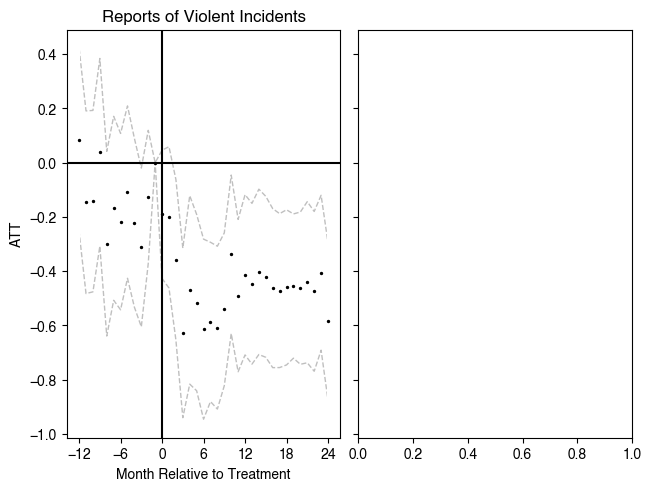

In [18]:
df = pd.read_csv(INPUT_DATA_PANEL)
treatment_date_variable = 'file_month'
analysis = f'group_1_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m'
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=analysis,
                                                     treatment_date_variable=treatment_date_variable,
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include_violent,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, layout="constrained")
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax1)

ax1.set_title("Reports of Violent Incidents")

In [19]:
dr_att_e_result['overall.att'][0]

-0.45744856532310046

In [20]:
df = pd.read_csv(INPUT_DATA_PANEL)
treatment_date_variable = 'file_month'
analysis = f'group_2_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m'
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)


dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=analysis,
                                                     treatment_date_variable=treatment_date_variable,
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include_non_violent,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary)
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax2)
ax2.set_title("Reports of Non-Violent Incidents")
ax2.set_ylabel("")
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_by_violence.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/1636734539.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [21]:
df = pd.read_csv(INPUT_DATA_PANEL)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=analysis,
                                                     treatment_date_variable='latest_docket_month',
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes_latest_docket_month.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3100130179.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


## HonestDiD

In [65]:
df = pd.read_csv(INPUT_DATA_PANEL)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis='group_0_crimes_250m',
                                                     treatment_date_variable='file_month',
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary,
                                                     min_e=-12,
                                                     max_e=24)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/1022085308.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [66]:
# Estimate pretrend slope
y = dr_att_e_result_tidy.loc[dr_att_e_result_tidy['event.time'] < 0, 'estimate']
x = dr_att_e_result_tidy.loc[dr_att_e_result_tidy['event.time'] < 0, 'event.time']
result = sm.OLS(y, sm.add_constant(x)).fit()
pretrend = result.params.round(2).loc['event.time']    

In [67]:
pretrend

-0.05

In [25]:
lower_bounds = []
upper_bounds = []
for event_time in range(0, 24):
    sensitivity_analysis_result = run_sensitivity_analysis_in_R(df=df,
                                            analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                            value_vars=weekly_value_vars_crime,
                                            period_to_int_dictionary=month_to_int_dictionary,
                                            event_time=event_time,
                                            type_and_vector_string='type="smoothness", Mvec = seq(from = 0, to = 0.01, by =0.0025)')
    lower_bounds.append(sensitivity_analysis_result[0][-1])
    upper_bounds.append(sensitivity_analysis_result[1][-1])
honest_did_upper_bounds = pd.Series(upper_bounds)
honest_did_lower_bounds = pd.Series(lower_bounds)

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  dropped 98 rows from original data due to missing data

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array 

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  dropped 98 rows from original data due to missing data

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to

R[write to console]:  dropped 98 rows from original data due to missing data

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in 

R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.




In [26]:
# Plot HonestDiD CIs
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
ax.fill_between(dr_att_e_result_tidy['event.time'].loc[dr_att_e_result_tidy['event.time'] >= 1], honest_did_upper_bounds, honest_did_lower_bounds, facecolor=(0,0,0,0), edgecolor='black',linestyle='-')
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes_honestdid.png"))

## Heterogeneous Treatment Effects

In [69]:
treatment_date_variable = 'file_month'

In [70]:
point_estimates = []
ci_uppers = []
ci_lowers = []
analysis = 'group_0_crimes_250m'
wald_p_values = []
for variable in ['med_hhinc2016',
                 'poor_share2010',
                 'popdensity2010', 
                 'share_white2010',]:
    # Read fresh copy of unrestricted dataset into memory.
    df = pd.read_csv(INPUT_DATA_PANEL)

    # Generate indicator variable for above median value of current characteristic
    median = df[variable].median()
    above_median_indicator_name = f'above_median_{variable}'
    df.loc[:, above_median_indicator_name] = 0
    df.loc[df[variable] > median, above_median_indicator_name] = 1
    above_median_df = df.loc[df[above_median_indicator_name] == 1, :]
    below_median_df = df.loc[df[above_median_indicator_name] == 0, :]
    
    # Cannot include pre-treatment covariates for power reasons
    pre_treatment_covariates = []

    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

    # Run DiD on above median sample
    att_e_result_tidy, att_e_result = run_did_in_R(df=above_median_df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)
    point_estimates.append(att_e_result['overall.att'][0])
    ci_lowers.append(att_e_result['overall.att'][0] - 1.96 * att_e_result['overall.se'])
    ci_uppers.append(att_e_result['overall.att'][0] + 1.96 * att_e_result['overall.se'])
    
    
    # Run DiD on below median sample
    att_e_result_tidy, att_e_result = run_did_in_R(df=below_median_df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)
    point_estimates.append(att_e_result['overall.att'][0])
    ci_lowers.append(att_e_result['overall.att'][0] - 1.96 * att_e_result['overall.se'])
    ci_uppers.append(att_e_result['overall.att'][0] + 1.96 * att_e_result['overall.se'])

    


fig, ax = plt.subplots()
figure_utilities.plot_labeled_vline(ax, x=0, text="", color='black', linestyle='-')
for i, (ci_lower, ci_upper) in enumerate(zip(ci_lowers, ci_uppers)):
    ax.hlines(y=i, xmin=ci_lower, xmax=ci_upper, color='black')
ax.scatter(point_estimates, range(len(point_estimates)), color='black', s=7)
ax.set_yticks(ticks=range(len(point_estimates)),
              labels=["Above median household income, 2016",
                      "Below median household income, 2016",
                      "Above median share below poverty line, 2010",
                      "Below median share below poverty line, 2010",
                      "Above median population density, 2010",
                      "Below median population density, 2010",
                      "Above median share white, 2010",
                      "Below median share white, 2010"])
ax.set_ylabel("Sample Restriction")
ax.set_xlabel("Average Post-Treatment ATT")

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "heterogenous_effects.png"))

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/753216769.py:11: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in att_gt(yname = "group_0_crimes_250m", tname = "month", idname = "case_number_numeric",  :
R[write to console]: 
 
R[write to console]:  Not returning pre-test Wald statistic due to singular covariance matrix

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in att_gt(yname = "group_0_crimes_250m", tname = "month", id

## Alternative Radii

In [71]:
treatment_date_variable = 'file_month'

In [72]:
fig, axes = plt.subplots(1, 2, layout='constrained', sharey=True)
radii = [constants.Analysis.MAIN_RESULTS_RADIUS, constants.Analysis.MAIN_RESULTS_RADIUS + 50]
titles = [f"Incident Reports Within {constants.Analysis.MAIN_RESULTS_RADIUS}m", f"Incident Reports Within {constants.Analysis.MAIN_RESULTS_RADIUS + 50}m"]
atts = []
att_ses = []
twenty_seventeen_totals = []
for ax, radius, title in zip(axes, radii, titles):
    df = pd.read_csv(INPUT_DATA_PANEL)
    twenty_seventeen_totals.append(df[f'total_twenty_seventeen_group_0_crimes_{radius}m'].mean())
    analysis = f"group_0_crimes_{radius}m"
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    pre_treatment_covariates = [f'total_twenty_seventeen_group_0_crimes_{radius}m',
                            f'month_neg_twelve_group_0_crimes_{radius}m',
                            f'month_neg_six_group_0_crimes_{radius}m',
                            'med_hhinc2016',
                            'poor_share2010',
                            'popdensity2010',
                            'share_white2010',
                            'non_payment']
    # Run DiD for current radius
    att_e_result_tidy, att_e_result = run_did_in_R(df=df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)
    # Plot event study 
    figure_utilities.plot_att_e(att_e_result_tidy,
                                att_e_result['overall.att'][0],
                                att_e_result['overall.se'][0], ax=ax)
    ax.set_title(title)

    # Keep track of overall ATTs and their SEs
    atts.append(att_e_result['overall.att'][0])
    att_ses.append(att_e_result['overall.se'][0])


figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_alternative_radii.png"))

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4157087833.py:8: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4157087833.py:8: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [73]:
for robustness_radius in constants.Analysis.ROBUSTNESS_RADII:
    df = pd.read_csv(INPUT_DATA_PANEL)
    analysis = f"group_0_crimes_{robustness_radius}m"
    twenty_seventeen_totals.append(df[f'total_twenty_seventeen_{analysis}'].mean())
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    pre_treatment_covariates = [f'total_twenty_seventeen_group_0_crimes_{radius}m',
                            f'month_neg_twelve_group_0_crimes_{radius}m',
                            f'month_neg_six_group_0_crimes_{radius}m',
                            'med_hhinc2016',
                            'poor_share2010',
                            'popdensity2010',
                            'share_white2010',
                            'non_payment']

    # Run DiD for current radius
    att_e_result_tidy, att_e_result = run_did_in_R(df=df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)

    # Keep track of overall ATTs and their SEs
    atts.append(att_e_result['overall.att'][0])
    att_ses.append(att_e_result['overall.se'][0])


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3394428759.py:2: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3394428759.py:2: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3394428759.py:2: DtypeWarning: Columns (8,2

In [74]:
# Build table
atts_aggregated = pd.DataFrame()
atts_aggregated.loc[:, 'Treatment Effect (S.E.)'] = pd.Series(atts).round(2).astype(str) + " " + "(" + pd.Series(att_ses).round(2).astype(str) + ")"
print(atts_aggregated)
atts_aggregated.loc[:, 'Total Incidents, 2017 (Mean Property)'] = pd.Series(twenty_seventeen_totals).round(2)
atts_aggregated.loc[:, 'Treatment Effect as \% of Mean'] = (100 * (pd.Series(atts) / atts_aggregated['Total Incidents, 2017 (Mean Property)'])).round(2).abs().astype(str)
atts_aggregated.loc[:, 'Total Incidents, 2017 (Mean Property)'] = atts_aggregated['Total Incidents, 2017 (Mean Property)'].astype(str)
atts_aggregated.index = ['250m away',
                         '300m away',
                         '250m and 300m away',
                         '250m and 350m away',
                         '250m and 400m away']
placebo_tests = pd.concat([pd.concat([atts_aggregated.iloc[0:2, :]], axis=0, keys=['Crimes Less Than']),
                pd.concat([atts_aggregated.iloc[2:6, :]], axis=0, keys=['Crimes Between'])], axis=0)
placebo_tests = figure_utilities.add_column_numbers(placebo_tests)

  Treatment Effect (S.E.)
0            -2.28 (0.82)
1            -1.94 (0.93)
2             0.36 (0.32)
3              1.0 (0.66)
4             0.67 (0.75)


In [75]:
latex = (placebo_tests
                 .style
                 .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
                 .to_latex(None,
                           column_format="llccc",
                           hrules=True,
                           multicol_align='c',
                           clines="skip-last;data"))
with open(os.path.join(OUTPUT_TABLES, "magnitudes_summary.tex"), 'w') as file:
    file.write(latex)
placebo_tests

Treatment Effect (S.E.)  \
                                                        (1)   
Crimes Less Than 250m away                     -2.28 (0.82)   
                 300m away                     -1.94 (0.93)   
Crimes Between   250m and 300m away             0.36 (0.32)   
                 250m and 350m away              1.0 (0.66)   
                 250m and 400m away             0.67 (0.75)   

                                    Total Incidents, 2017 (Mean Property)  \
                                                                      (2)   
Crimes Less Than 250m away                                         350.35   
                 300m away                                         482.41   
Crimes Between   250m and 300m away                                 132.0   
                 250m and 350m away                                284.98   
                 250m and 400m away                                 449.5   

                                    Treatment Effect as \% of Mean  
                                                               (3)  
Crimes Less Than 250m away                                    0.65  
                 300m away                                     0.4  
Crimes Between   250m and 300m away                           0.27  
                 250m and 350m away                           0.35  
                 250m and 400m away                           0.15

## Plot Treatment Effects As Radius is Gradually Increased

In [86]:
atts = []
ses = []
for radius in list(range(210, 310, 10)):
    print(radius)
    df = pd.read_csv(INPUT_DATA_PANEL)
    analysis = f'group_0_crimes_{radius}m'
    treatment_date_variable = "file_month"
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    unc_att_e_result_tidy, unc_att_e_result = run_did_in_R(df=df,
                                                           analysis=analysis,
                                                           treatment_date_variable=treatment_date_variable,
                                                           pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                           value_vars=weekly_value_vars_crime,
                                                           period_to_int_dictionary=month_to_int_dictionary)

    atts.append(unc_att_e_result['overall.att'][0])
    ses.append(unc_att_e_result['overall.se'][0])

210


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



220


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



230


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



240


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



250


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



260


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



270


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



280


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



290


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



300


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/4056917349.py:5: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



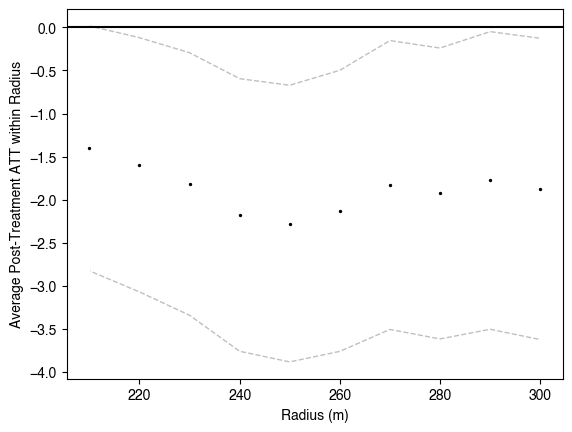

In [87]:
fig, ax = plt.subplots()
figure_utilities.plot_scatter_with_shaded_errors(ax=ax,
                                                 x=pd.Series(list(range(210, 310, 10))),
                                                 y=pd.Series(atts),
                                                 y_upper=pd.Series(atts) + 1.96 * pd.Series(ses),
                                                 y_lower=pd.Series(atts) - 1.96 * pd.Series(ses),
                                                 point_color='black',
                                                 error_color='white',
                                                 edge_color='grey',
                                                 edge_style='--',
                                                 zorder=1)
figure_utilities.plot_labeled_hline(ax, y=0, text="", color='black', linestyle='-', zorder=6)
ax.set_ylabel("Average Post-Treatment ATT within Radius")
ax.set_xlabel("Radius (m)")
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unc_by_radius.png"))

# Permitting

In [34]:
# Set constants
total_value_thresholds = [5000]

In [35]:
df = pd.read_csv(INPUT_DATA_PANEL)

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/739836696.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


In [78]:
for total_value_threshold in total_value_thresholds:
    # Plot share of properties with at least $5000k in active permits in each group
    for treatment_date_variable in ['file_month']:

        fig, (ax_dr, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(6, 6), layout='constrained')

        df = pd.read_csv(INPUT_DATA_PANEL)
        for col in df.columns:
            if "total_value" in col:
                df[col.replace("total_value", f"total_value_above_{total_value_threshold}")] = np.where(df[col] >= total_value_threshold, 1, 0)
                df = df.copy()
        result = run_event_study(df,
                                 treatment_date_variable,
                                 f"total_value_above_{total_value_threshold}")
        # Normalize omitted period to zero
        omitted_period = pd.Series([0, 0], index=['month_-1', 'month_-1_X_treatment_indicator'])
        result.params = pd.concat([result.params, omitted_period], axis=0)
        month = []
        treatment = []
        control = []
        for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD):
            month.append(i)
            control.append(result.params[f'month_{i}'] + result.params['const'])
            treatment.append((result.params['judgment_for_plaintiff'] +
                               result.params[f'month_{i}_X_treatment_indicator'] +
                               result.params[f'month_{i}']  +
                              result.params['const']))

        l2, = ax1.plot(month,
            control,
            color='grey',
            linestyle='-',
            marker='o',
            markersize=2,
            label="Properties where Tenant Won")
        l1, = ax1.plot(month,
                treatment,
                color='black',
                linestyle='-',
                marker='o',
                markersize=2,
                label="Properties where Plaintiff Won")
        print(f"Current threshold: {total_value_threshold}")
        print(pd.Series(treatment, index=range(-12, 24)) / pd.Series(control, index=range(-12, 24)))
        ax1.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD + 1, 6),
                      range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD + 1, 6))

        ax1.set_ylabel(f"More than ${total_value_threshold} in Active Pemits")
        ax1.axvline(0, color='black')
        ax1.legend()

        df = pd.read_csv(INPUT_DATA_PANEL)
        mask = (
                ((df.filter(regex='2019-\d\d_total_value') > total_value_threshold).sum(axis=1) == 0) & 
                ((df.filter(regex='2020-\d\d_total_value') > total_value_threshold).sum(axis=1) == 0) & 
                ((df.filter(regex='2021-\d\d_total_value') > total_value_threshold).sum(axis=1) == 0))
        df = df.loc[mask, :]
        
        weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, 
                                                                                                             "group_0_crimes_250m")
        dr_att_e_result_tidy_subsample, dr_att_e_result_subsample = run_did_in_R(df=df,
                                                               analysis="group_0_crimes_250m",
                                                               treatment_date_variable=treatment_date_variable,
                                                               pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                               value_vars=weekly_value_vars_crime,
                                                               period_to_int_dictionary=month_to_int_dictionary,
                                                               min_e=-12,
                                                               max_e=24)
        figure_utilities.plot_att_e(dr_att_e_result_tidy_subsample,
                                    dr_att_e_result_subsample['overall.att'][0],
                                    dr_att_e_result_subsample['overall.se'][0], ax=ax2)

        figure_utilities.plot_att_e(dr_att_e_result_tidy,
                                    dr_att_e_result['overall.att'][0],
                                    dr_att_e_result['overall.se'][0], ax=ax_dr)
        ax_dr.set_xlabel("")
        ax_dr.set_title("Treatment Effects of Eviction on Incident Reports")
        ax1.set_title("Trends in Permitting Around Case Filing")
        ax2.set_title("Treatment Effects of Eviction on Incident Reports,\nExcluding Properties with at Least $5000 in Active Permits")
        figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"permits_figure_{total_value_threshold}.png"))

        

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3772401497.py:7: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)


Current threshold: 5000
-12    1.071326
-11    0.972129
-10    0.984338
-9     1.085754
-8     1.310107
-7     1.183322
-6     0.935650
-5     0.853093
-4     0.853093
-3     0.938402
-2     1.088429
-1     0.986389
0      0.974963
1      1.152828
2      1.198941
3      1.316200
4      1.215657
5      1.144940
6      1.279639
7      1.199662
8      1.045727
9      1.127301
10     1.492912
11     1.906913
12     1.620876
13     1.462445
14     1.584315
15     1.434747
16     1.315185
17     1.345262
18     1.371042
19     1.336512
20     1.364948
21     1.500267
22     1.611397
23     1.842680
dtype: float64


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3772401497.py:52: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



# Scaling

In [79]:
df = pd.read_csv(INPUT_DATA_PANEL)
mask = (
    ((df.filter(regex='2019-\d\d_total_value') > 5000).sum(axis=1) == 0) & 
    ((df.filter(regex='2020-\d\d_total_value') > 5000).sum(axis=1) == 0) & 
    ((df.filter(regex='2021-\d\d_total_value') > 5000).sum(axis=1) == 0))
df = df.loc[mask, :]

weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, 
                                                                                                 "group_0_crimes_250m")
dr_att_e_result_tidy_subsample, dr_att_e_result_subsample = run_did_in_R(df=df,
                                                   analysis="group_0_crimes_250m",
                                                   treatment_date_variable='file_month',
                                                   pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary,
                                                   min_e=-12,
                                                   max_e=24)

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/3144126554.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [80]:
df = pd.read_csv(INPUT_DATA_PANEL)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis="group_0_crimes_250m",
                                                     treatment_date_variable='file_month',
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary,
                                                     min_e=-12,
                                                     max_e=24)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_74757/1542779290.py:1: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_PANEL)
R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [81]:
mean_total_crimes_2017 = df.loc[df['judgment_for_plaintiff'] == 1, 'total_twenty_seventeen_group_0_crimes_250m'].mean()

In [82]:
overall_att = dr_att_e_result['overall.att'][0]

In [83]:
no_permits_att = dr_att_e_result_subsample['overall.att'][0]

In [84]:
no_permits_att / (mean_total_crimes_2017/12)

-0.03373432560607381

In [85]:
overall_att / (mean_total_crimes_2017/12)

-0.07829807386756617

In [ ]:
att_es_no_permits = dr_att_e_result_tidy_subsample.set_index('event.time')
no_permits_first_year_total = att_es_no_permits.loc[1:12]['estimate'].sum()
att_es = dr_att_e_result_tidy.set_index('event.time')
full_sample_first_year_total = att_es.loc[1:12]['estimate'].sum()

In [ ]:
no_permits_first_year_total

In [ ]:
full_sample_first_year_total

In [ ]:
df = pd.read_csv(INPUT_DATA_PANEL)

In [ ]:
no_permits_first_year_total / df.loc[df['judgment_for_plaintiff'] == 1, 'total_twenty_seventeen_group_0_crimes_250m'].mean()

In [ ]:
24 / ()

## Write Statistics to File

In [68]:
with open(OUTPUT_STATISTICS, 'w') as file:
    group_0_att_250m = placebo_tests.loc[('Crimes Less Than', '250m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroatt{'{' + str(group_0_att_250m) + ' }'}\n")

    group_0_att_250m_se = (placebo_tests.loc[('Crimes Less Than', '250m away'), ('Treatment Effect (S.E.)', '(1)')]
                           .split(" ")[1]
                           .replace("(", "")
                           .replace(")", ""))
                           
    file.write(f"\n\\def\\groupzeroattse{'{' + str(group_0_att_250m_se) + '}'}\n")

    group_0_att_250m_unconditional = unc_att_e_result['overall.att'][0]
    file.write(f"\n\\def\\groupzeroattunconditional{'{' + f'{group_0_att_250m_unconditional : .2f}' + '}'}\n")
    
    group_0_att_250m_unconditional_se = unc_att_e_result['overall.se'][0]
    file.write(f"\n\\def\\groupzeroattunconditionalse{'{' + f'{group_0_att_250m_unconditional_se : .2f}' + '}'}\n")


    group_0_att_250m_as_percent_of_mean = placebo_tests.loc[('Crimes Less Than', '250m away'), ('Treatment Effect as \% of Mean', '(3)')]
    file.write(f"\n\\def\\groupzeroattaspercentofmean{'{' + str(group_0_att_250m_as_percent_of_mean) + ' }'}\n")
    
    
    group_0_att_350m = placebo_tests.loc[('Crimes Less Than', '300m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroattwide{'{' + str(group_0_att_350m) + ' }'}\n")
 
    group_0_att_250_300m = placebo_tests.loc[('Crimes Between', '250m and 300m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroattdonut{'{' + str(group_0_att_250_300m) + ' }'}\n")
    
    group_0_att_250_400m = placebo_tests.loc[('Crimes Between', '250m and 400m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroattdonutwide{'{' + str(group_0_att_250_400m) + ' }'}\n")

    file.write(f"\n\\def\\percentfallcontrolgroup{'{' + str(percent_fall_control_group) + ' }'}\n")

    file.write(f"\n\\def\\percentfalltreatmentgroup{'{' + str(percent_fall_treatment_group) + ' }'}\n")

    file.write(f"\n\\def\\smallestposttreatmentpercentchange{'{' + str(smallest_post_treatment_percent_change) + ' }'}\n")

    file.write(f"\n\\def\\numpretreatmentcovariates{'{' + str(len(constants.Variables.pre_treatment_covariates_to_include)) + ' }'}\n")
    
    
    file.write(f"\n\\def\\pretrend{'{' + str(pretrend) + '}'}\n")


